# Optimization

An introduction to optimization in reactor design

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy.integrate import trapezoid
from math import ceil, floor
import time

## Review: Flow Reactors in Series

Over the past couple of weeks, we have considered the idea of reactor sequencing for flow reactors. That is, we have considered whether it would be beneficial to use more than one flow reactor arranged in a sequence in order to accomplish a certain transformation. For now, we're only considering reactors in series where the outflow from one is the inflow to the next. For now, we are only really concerned with concepts about how placing reactors in sequences affects the process, and so we are looking at a very simple reaction:

$$A \longrightarrow B$$

Whether we perform this reaction in a CSTR or a PFR, we can assume that the temperature, pressure, density, volume, and volumetric flowrate associated with these processes are constant with respect to time and position in the reactor. With those simplifying assumptions, we can write balances for the "nth" reactor in that system, e.g., for a CSTR:

$$V_n = \frac {F_{A_f}(x_{A_n} - x_{A_{n-1}})}{r(x_{A_n})}$$

And for a PFR:

$$V_n = \int_{x_{A_{n-1}}}^{x_{A_n}} \frac{F_{A_f}}{r(x_A)}dx_A$$

Today, we will specifically consider reactor sizing for the case where the reaction given above is first order in species A such that $r = kC_A$; further, we are given the following information about this reactor:

\begin{align}
    k &= 1 \ \textrm{min}^{-1} \\
    F_{A_f} &= 1 \ \textrm{mol} \ \textrm{min}^{-1} \\
    C_{A_f} &= 1 \ \textrm{mol} \ \textrm{L}^{-1} \\
\end{align}

### Balances on the n<sup>th</sup> PFR and CSTR in a series

We developed the following balances for the nth CSTR and PFR during class:

$$V_{CSTR} = \frac{F_{Af}(x_{A_n} - x_{A_{n-1}})}{kC_{A_f}(1 - x_{A_n})}$$

$$V_{PFR} = \int_{x_{A_{n-1}}}^{x_{A_n}} \frac{F_{A_f}}{kC_{A_f}(1 - x_{A_n})}dx_A $$

### 90% conversion in a single flow reactor

We can substitute the information in the problem statement to compute the size of a single CSTR and a single PFR to achieve 90% conversion of species A.  Doing so, we find:

$$V_{CSTR} = \frac{F_{Af}(x_{A_n} - x_{A_{n-1}})}{kC_{A_f}(1 - x_{A_n})} = \frac{0.9}{(1-0.9)} \textrm{L} = 9.0 \textrm{L}$$

$$V_{PFR} = \int_{x_{A_{n-1}}}^{x_{A_n}} \frac{F_{A_f}}{r(x_A)}dx_A = \int_{0}^{0.9} \frac{F_{A_f}}{kC_{A_f}(1-x_A)}dx_A = -\ln{(1 - 0.9)} \textrm{L} = 2.30 \textrm{L}$$

Both of these models are embedded in the next cell as lambda functions.  They will calculate the volume of a single CSTR or PFR required to achieve any fractional conversion in this reactor.  I've also plotted them so that you can see how the difference in sizes grows as the fractional conversion increases.  This makes sense if you think about the requirement that the entire volume of the CSTR operates at the exit concentration, i.e., where the reaction rate is at its lowest (for a positive order reaction).

To achieve 90% conversion, we need a 9.00L CSTR or a 2.30L PFR


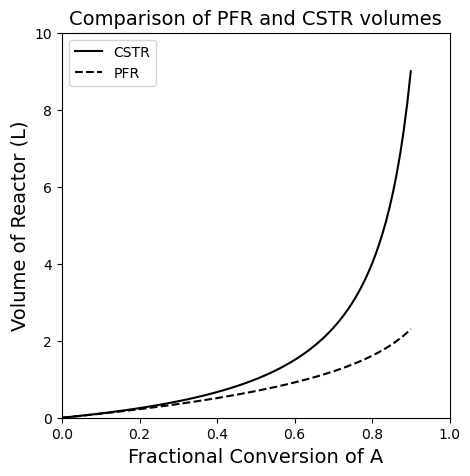

In [2]:
FAf = 1 #mol/min
CAf = 1 #mol/L
k   = 1 #1/min

VCSTR = lambda X: FAf/k/CAf*X/(1 - X)
VPFR  = lambda X: -FAf/k/CAf*np.log(1 - X)
print(f'To achieve 90% conversion, we need a {VCSTR(0.9):3.2f}L CSTR or a {VPFR(0.9):3.2f}L PFR') 
VPFR(0.9)
xspan = np.linspace(0, 0.9, 100)

plt1 = plt.figure(1, figsize = (5, 5))
plt.title('Comparison of PFR and CSTR volumes', fontsize = 14)
plt.plot(xspan, VCSTR(xspan), color = 'black', linestyle = 'solid', label = 'CSTR')
plt.plot(xspan, VPFR(xspan), color = 'black', linestyle = 'dashed', label = 'PFR')
plt.xlim(0, 1.0)
plt.ylim(0, 10.0)
plt.xlabel('Fractional Conversion of A', fontsize = 14)
plt.ylabel('Volume of Reactor (L)', fontsize = 14)
plt.legend()
plt.show()

### A Levenspiel Plot for this system

This is also evident from a Levenspiel plot, where we present $\frac{F_{A_f}}{r(x_A)}$ vs. $x_A$

To achieve 90% conversion, we need a 9.00L CSTR or a 2.30L PFR


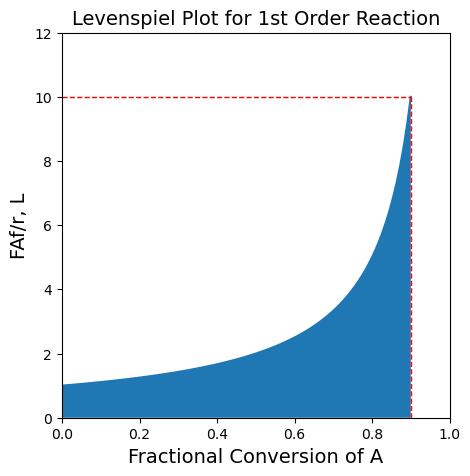

In [3]:
LEV  = lambda X: FAf/k/CAf/(1 - X)
VC   = LEV(0.9)*(0.9 - 0.0)
VP   = trapezoid(LEV(xspan), xspan)
print(f'To achieve 90% conversion, we need a {VC:3.2f}L CSTR or a {VP:3.2f}L PFR') 

plt2 = plt.figure(1, figsize = (5, 5))
plt.plot(xspan, LEV(xspan))
plt.hlines(LEV(0.9), 0, 0.9, linestyle = 'dashed', color = 'red', linewidth = 1)
plt.vlines(0.9, 0, LEV(0.9), linestyle = 'dashed', color = 'red', linewidth = 1)
plt.fill_between(xspan, LEV(xspan))
plt.xlabel('Fractional Conversion of A', fontsize = 14)
plt.ylabel('FAf/r, L', fontsize = 14)
plt.title('Levenspiel Plot for 1st Order Reaction', fontsize = 14)
plt.ylim(0, 12)
plt.xlim(0, 1)
plt.show()

### If we use 2 CSTRs instead of 1 CSTR, the total volume required is lower...

We also looked at how things change when we instead do this in multiple reactors; for example, if we decide to reach 90% total conversion of A in two CSTRs in series, with an intermediate conversion of 45%, we find:

$$V_1 = \frac{F_{A_f}(x_{A_n} - x_{A_{n-1}})}{kC_{A_f}(1-x_{A_{n-1}})} = \frac{(0.45 - 0.00)}{(1 - 0.45)} \ \textrm{L} = 0.82 \ \textrm{L}$$\
$$V_2 = \frac{F_{A_f}(x_{A_n} - x_{A_{n-1}})}{kC_{A_f}(1-x_{A_{n-1}})} = \frac{(0.90 - 0.45)}{(1 - 0.90)} \ \textrm{L} = 4.5 \ \textrm{L}$$\
$$V_{\textrm{total}} = V_1 + V_2 = 5.32 \ \textrm{L}$$

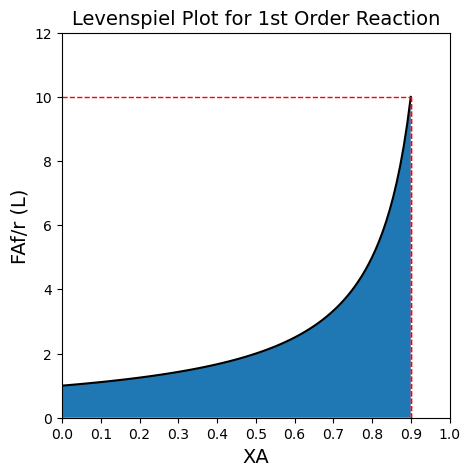

In [4]:
XAset = np.linspace(0, 0.90, 100)
XMAX = max(XAset)
XMID  = 0.90

plt3 = plt.figure(1, figsize = (5, 5))
plt.title('Levenspiel Plot for 1st Order Reaction', fontsize = 14)
plt.plot(XAset, LEV(XAset), color = 'black')
plt.fill_between(XAset, LEV(XAset))
plt.vlines(XMID, 0, LEV(XMAX), linestyle = 'dashed', color = 'red', linewidth = 1)
plt.vlines(XMAX, 0, LEV(XMAX), linestyle = 'dashed', color = 'red', linewidth = 1)
plt.hlines(LEV(XMAX), XMID, XMAX, linestyle = 'dashed', color = 'red', linewidth = 1)
plt.hlines(LEV(XMID), 0, XMID, linestyle = 'dashed', color = 'red', linewidth = 1)
plt.ylabel('FAf/r (L)', fontsize = 14)
plt.xlabel('XA', fontsize = 14)
plt.xlim(0,1)
plt.ylim(0, 12)
plt.xticks(np.linspace(0, 1, 11))
plt.show()

# Problem 1: What is the optimum intermediate conversion?

Surely, there is a better choice of intermediate conversion of A that 0.45, right?  We can see from the Levenspiel plot that as I vary the exit conversion from the first reactor, I will change the size of both reactors...and it isn't immediately clear how I should operate this process so that I have the smallest total possible CSTR volume.

### Optimizing the intermediate conversion: a graphical solution

Let's solve that problem using a handful of methods.  First, let's return to the analytical solution for the total volume of two CSTRs in series:

$$V = \frac {F_{A_f} (x_{A_1} - x_{A_{0}} ) } {kC_{A_f}(1-x_{A_{1}})} + \frac {F_{A_f} (x_{A_2} - x_{A_{1}} ) } {kC_{A_f}(1-x_{A_{2}})} $$

Here, we know that $x_{A_0} = 0$ and that $x_{A_2} = 0.9$, but we'll leave $x_{A_1}$, which is the intermediate conversion, as an unknown. 

$$V = \frac{F_{A_f}}{kC_{A_f}} \left[ \frac {x_{A_1}}{(1-x_{A_{1}})} + \frac {(0.9 - x_{A_{1}} )} {0.1} \right] $$

Let's program that information into a function in the cell below, and we'll learn some ways to analyze it; the most intuitive way is a graphical method.

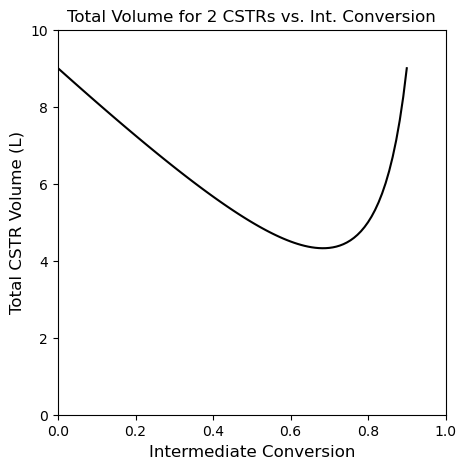

In [5]:
def f1(X):
    FAf = 1 #mol/min
    CAf = 1 #mol/L
    k   = 1 #1/min    
    V = FAf/k/CAf*(X/(1 - X) + (0.9 - X)/0.1)
    return V
xspan = np.linspace(0, 0.9, 100)
V = f1(xspan)

plt4 = plt.figure(1, figsize = (5, 5))
plt.title('Total Volume for 2 CSTRs vs. Int. Conversion')
plt.plot(xspan, V, color = 'black')
plt.xlabel('Intermediate Conversion', fontsize = 12)
plt.ylabel('Total CSTR Volume (L)', fontsize = 12)
plt.xlim(0, 1)
plt.ylim(0, 10)
plt.show()

### Optimizing the intermediate conversion: analytical solution

Arguably, the best way to solve this would be to take the derivative of the volume function with respect to fractional conversion and find the point where the derivative is equal to zero (generally, this is a maximum or a minimum value in a function). This is somewhat tedious, but it isn't difficult.  Doing so, we find:

$$\frac{dV}{dx_{A_1}} = \frac{F_{A_f}}{kC_{A_f}} \left[ \frac{ (1-x_{A_1}) + x_{A_1} }{ (1 - x_{A_1})^2} - 10\right]$$

To find the minimum, all we do is solve the following equation for $x_{A_1}$:

$$0 = \frac{1}{(1 - x_{A_1})^2} - 10$$

And then plug that result back into our volume expression

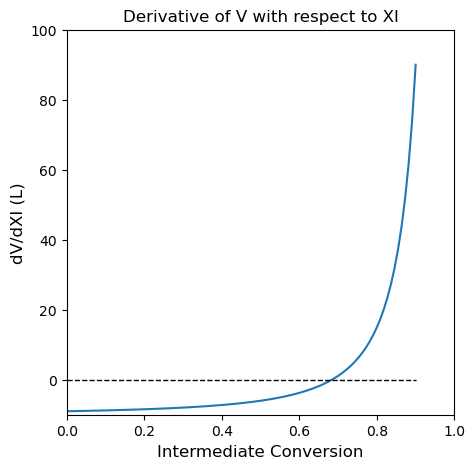

In [6]:
der  = lambda X: 1/(1 - X)**2 - 10

plt5 = plt.figure(1, figsize = (5, 5))
plt.title('Derivative of V with respect to XI')
plt.plot(xspan, der(xspan))
plt.hlines(0, 0, 0.9, linestyle = 'dashed', color = 'black', linewidth = 1)
plt.xlim(0.0, 1.0)
plt.xlabel('Intermediate Conversion', fontsize = 12)
plt.ylim(-10.0, 100.0)
plt.ylabel('dV/dXI (L)', fontsize = 12)
plt.show(1)

In [7]:
Xopt = opt.newton(der, 0.5)
Vmin = f1(Xopt)
print(f'The optimum intermediate conversion is {Xopt:3.2f}, which gives a total volume of {Vmin:3.2f}L')

The optimum intermediate conversion is 0.68, which gives a total volume of 4.32L


### Optimizing the intermediate conversion: a numerical solution

Alternatively, we can use a numerical method (e.g., see Gauss-Newton Method or Course Supplement packet on Minimization).  This is similar to using Excel's solver to minimize a function value.  All we do is write an objective function that we want to minimize with respect to a certain variable.  In this case, we want to **minimize** total CSTR volume in two CSTRs in series **with respect to** intermediate fractional conversion, $x_{A_1}$.  We already have written an appropriate objective function here that gives us the total reactor volume as a function of intermediate conversion.

There are a few options available. A useful method for scalar functions is `scipy.optimize.minimize_scalar()`, which is designed specifically to optimize (find the minimum of) univariate, scalar functions.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize_scalar.html

In the cells below, we'll see how to change a few options with minimize scalar to account for additional complexities in the functions we are trying to minimize.  These include changing methods, adding brackets or bounds, and adding options.

In [8]:
def f2(X):
    #print(f'Current int. conversion is {X:0.2f}')
    FAf = 1 #mol/min
    CAf = 1 #mol/L
    k   = 1 #1/min
    V = FAf/k/CAf*(X/(1.0 - X) + (0.9 - X)/0.1)
    #print(f'Which gives a Total volume of {V:0.2f}L \n')
    return V

In [9]:
# opt.minimize_scalar(f2)
# opt.minimize_scalar(f2, method = 'Brent') #uses a default bracket of (0, 1)
# opt.minimize_scalar(f2, method = 'Brent', bracket = (0.1, 0.9))
# opt.minimize_scalar(f2, method = 'Bounded', bounds = (0.1, 0.9))
# optset = {'disp' : True}
# optset['disp']
# optset = {'disp' : True, 'maxiter' : 100}
# opt.minimize_scalar(f2, method = 'Brent', bracket = (0.1, 0.9), options = optset)
# ans2 = opt.minimize_scalar(f2, method = 'Brent', bracket = (0.1, 0.9), options = optset)

A more general optimization tool is `scipy.optimize.minimize()` which will work on either univariate or multivariate optimization problems.  At some level, a useful analogy would be that `scipy.optimize.minimize_scalar()` is similar to `scipy.optimize.newton()` in that they only work for univariate scalar functions and they take a scalar for an argument.  In contrast, `scipy.optimize.minimize()` is similar to `scipy.optimize.root()` in that it can handle multivariate problems and it takes an array argument as an input.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize

As above, there is a lot of flexibility with `scipy.optimize.minimize()` and in the cells below we'll see how to change the method, add bounds, add options, and even add constraints to the problem.

In [10]:
def f3(var):
    X = var[0]
    #print(f'Current int. conversion is {X:0.2f}')
    FAf = 1 #mol/min
    CAf = 1 #mol/L
    k   = 1 #1/min
    V = FAf/k/CAf*(X/(1.0 - X) + (0.9 - X)/0.1)
    #print(f'Which gives a Total volume of {V:0.2f}L \n')
    return V

In [11]:
opt.minimize(f3, 0.5)
opt.minimize(f3, 0.5, method = 'Nelder-Mead')
opt.minimize(f3, 0.5, method = 'Nelder-Mead', bounds = [(0.1, 0.9),])
opt.minimize(f3, 0.5, method = 'SLSQP', bounds = [(0.1, 0.9),])

optset = {'disp' : True, 'maxiter' : 50}
opt.minimize(f3, 0.5, method = 'SLSQP', bounds = [(0.1, 0.9),], options = optset)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.324555701610383
            Iterations: 6
            Function evaluations: 14
            Gradient evaluations: 6


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 4.324555701610383
       x: [ 6.837e-01]
     nit: 6
     jac: [-6.942e-03]
    nfev: 14
    njev: 6

In [12]:
constraintfun1 = lambda X: 0.4 - X
constraint_dictionary = {'type' : 'ineq' , 'fun' : constraintfun1}
opt.minimize(f3, 0.01, method = 'SLSQP', constraints = (constraint_dictionary))

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 5.666666666667521
       x: [ 4.000e-01]
     nit: 2
     jac: [-7.222e+00]
    nfev: 4
    njev: 2

# Problem 2

Now let's solve a slightly different problem. The previous example minimized the Volume (capex) of 2 reactors by varying the intermediate conversion. But let's say that we want to minimize the total cost of our *process*, which needs to account for CapEx (increases with the size of a reactor) and OpEx (arguably, increases with the number of reactors).  Let's construct a very simple model for this.  We will say that the annualized total capital cost of our reactors is given by:

$$\textrm{CapEx} = 3.78V^{2.3} + 20$$

Where V is volume of a reactor  in L and CapEx has units of M\\$ per year. OpEx will also have units of M\\$ per year and scale with the number of reactors that we have in the following way:

$$\textrm{OpEx} = 165.3N^\frac{1}{3}$$

And we'll say that, for this simple example, the total cost of the process is just CapEx plus OpEx.

Our final assumption: Each reactor in the series will accomplish the same incremental change in fractional conversion of species A. For example, if we achieve 90% conversion in 2 reactors, each will achieve 45% conversion of $F_{A_f}$.  If we have 10 reactors, each will achieve 9% conversion of $F_{A_f}$, etc. 

That way, the change in fractional conversion (amount converted) across any reactor is constant, and our CSTR balance on reactor n becomes:

$$V_n = \frac{F_{A_f}\Delta x_A}{kC_{A_f}(1 - x_{A_n})}$$

We will keep the rest of the information about this problem the same as in Problem 1, i.e.,:

\begin{align}
    r &= kC_A \\
    k &= 1 \ \textrm{min}^{-1} \\
    F_{A_f} &= 1 \ \textrm{mol} \ \textrm{min}^{-1} \\
    C_{A_f} &= 1 \ \textrm{mol} \ \textrm{L}^{-1} \\
\end{align}

How many reactors should we use in order to minimize the total cost of the process?

In [13]:
def volcalcn(n):
    FAf = 1 #mol/min
    CAf = 1 #mol/L
    k   = 1 #1/min
    XA  = 0.90
    DX  = XA/n
    Vn  = FAf*DX/k/CAf/(1 - 0.9)
    return Vn
volcalcn(1)

9.000000000000002

In [14]:
def volcalc(N):
    FAf = 1 #mol/min
    CAf = 1 #mol/L
    k   = 1 #1/min
    XA  = 0.9
    DX  = XA/N
    
    reactorset = np.linspace(1, N, N)
    V   = np.zeros(N)
    
    for index, n in enumerate(reactorset):
         V[index] = FAf/CAf/k*DX/(1 - n*DX)
    Vtot = sum(V)
    return [Vtot, V]
volcalc(1.0)

TypeError: 'float' object cannot be interpreted as an integer

In [ ]:
def obj(N):
    Vtot, V = volcalc(N)
    CAPEX = 3.78*V**(2.3) + 20
    CAPEX = np.sum(CAPEX)
    OPEX  = 165.3*N**(1/3)
    COST  = CAPEX + OPEX
    return [CAPEX, OPEX, COST]

In [ ]:
CAPEX = np.zeros(20)
OPEX  = np.zeros(20)
COST  = np.zeros(20)

nreact = np.linspace(1, 20, 20, dtype = int)
for i, N in enumerate(nreact):
    CAPEX[i], OPEX[i], COST[i] = obj(N)

In [ ]:
plt.scatter(nreact, CAPEX, color = 'none', edgecolor = 'blue',  marker = 'o', label = 'CAPEX')
plt.scatter(nreact, OPEX,  color = 'none', edgecolor = 'red',   marker = 'o', label = 'OPEX')
plt.scatter(nreact, COST,  color = 'none', edgecolor = 'black', marker = 's', label = 'Cost')
plt.xlim(0, 20)
plt.ylim(0, 1000)
plt.xticks(np.linspace(0, 20, 21))
plt.xlabel('Number of Reactors')
plt.ylabel('Cost ($)')
plt.legend()
plt.show()